# Import all kind of stuff

In [1]:
import numpy as np

from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D

import superconductivity.api as sc

from superconductivity.api import G_0_muS
from superconductivity.api import NDArray64

from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("reload_ext", "autoreload")
    _ip.run_line_magic("autoreload", "2")

    _ip.run_line_magic(
        "config",
        "InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}",
    )
    _ip.run_line_magic("config", 'InlineBackend.figure_format = "retina"')  # or "png"
    _ip.run_line_magic(
        "config", "InlineBackend.rc = {'figure.dpi': 300}"
    )  # choose a value you like

In [2]:
from superconductivity.style.thesislayout import Remote

data = np.genfromtxt(
    f"{Remote}/theory/schema/PG.csv",
    delimiter=",",
)
PG_x = data[:, 0]
PG_y = data[:, 1]
mask = np.where(PG_x <= 4.8, True, False)
PG_x = PG_x[mask]
PG_y = PG_y[mask]

data = np.genfromtxt(
    f"{Remote}/theory/schema/Gx.csv",
    delimiter=",",
)
Gx_x = data[:, 0]
Gx_y = data[:, 1]
Gx_y = (Gx_y - 1) / 0.75
Gx_x -= np.min(Gx_x)

data = np.genfromtxt(
    f"{Remote}/theory/schema/GV.csv",
    delimiter=",",
)
GV_x = data[:, 0]
GV_y = data[:, 1]
GV_y = np.flip(GV_y)
# GV_x = np.flip(GV_x)

GV_x = GV_x[460:]
GV_y = GV_y[460:]

GV_x -= np.min(GV_x)
# GV_x /= 0.8

figsize = 1.3, 1

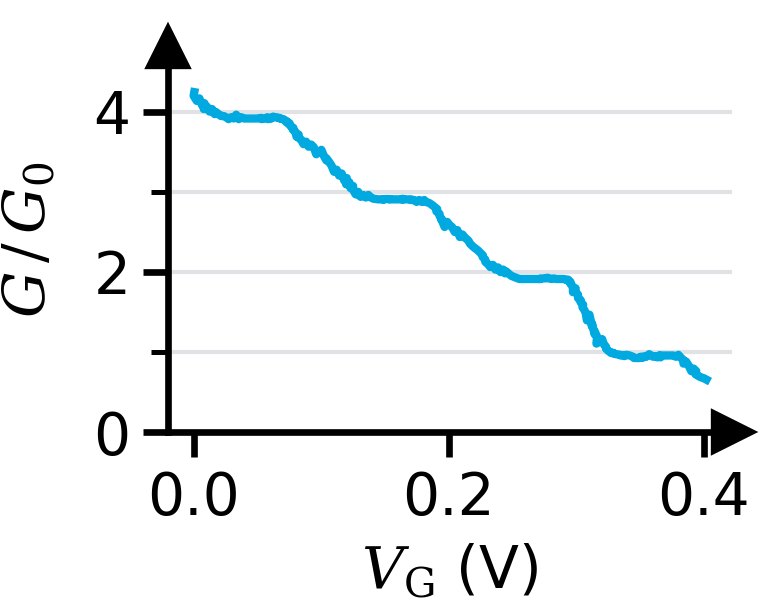

In [3]:
fig, ax = sc.get_figure(figsize=figsize)
ax.plot(
    GV_x,
    GV_y,
    "-",
    color=sc.seeblau100,
)

ax.set_ylim((0, 4.8))
ax.set_yticks([0, 2, 4])

from matplotlib.ticker import MultipleLocator

ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.grid(
    visible=True,
    color=sc.seegrau20,
    which="both",
    linewidth=0.5,
    linestyle="-",
    axis="y",
)

xlabel = "$V_\\mathrm{G}$ (V)"
ylabel = "$G\\,/\\,G_0$"
title = "theory/basics/GV"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

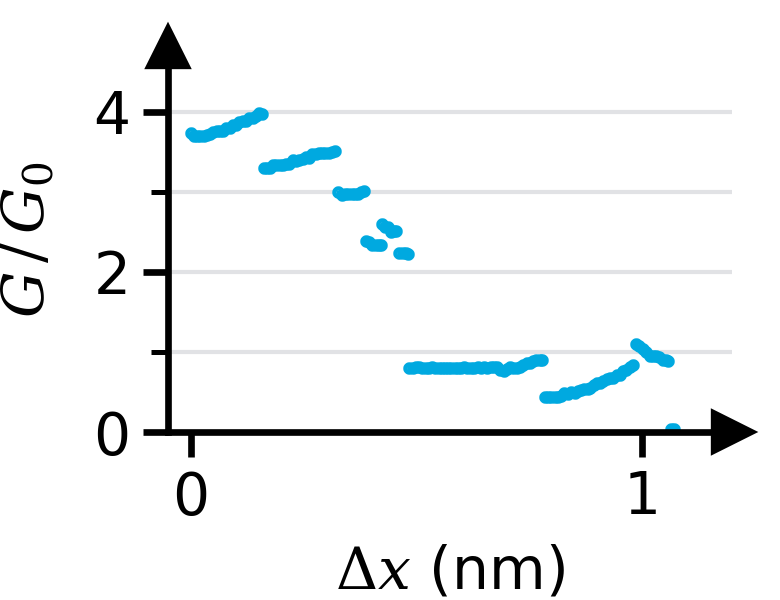

In [4]:
fig, ax = sc.get_figure(figsize=figsize)
ax.plot(
    Gx_x,
    Gx_y,
    ".",
    color=sc.seeblau100,
)

ax.set_ylim((0, 4.8))
ax.set_yticks([0, 2, 4])

from matplotlib.ticker import MultipleLocator

ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlim(-0.05, 1.2)
ax.set_xticks([0, 1.0])

ax.grid(
    visible=True,
    color=sc.seegrau20,
    which="both",
    linewidth=0.5,
    linestyle="-",
    axis="y",
)

xlabel = "$\\Delta x$ (nm)"
ylabel = "$G\\,/\\,G_0$"
title = "theory/basics/Gx"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

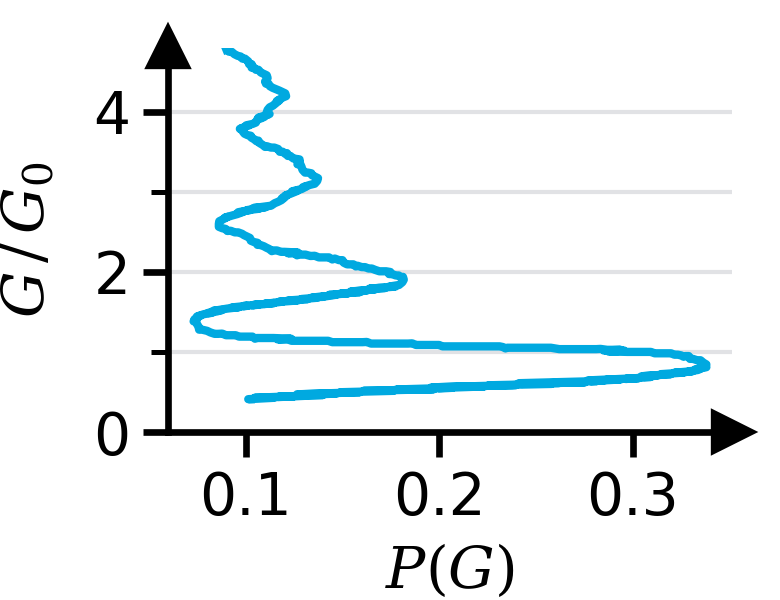

In [5]:
fig, ax = sc.get_figure(figsize=figsize)
ax.plot(
    PG_y,
    PG_x,
    "-",
    color=sc.seeblau100,
)

ax.set_ylim((0, 4.8))
ax.set_yticks([0, 2, 4])

from matplotlib.ticker import MultipleLocator

ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.grid(
    visible=True,
    color=sc.seegrau20,
    which="both",
    linewidth=0.5,
    linestyle="-",
    axis="y",
)

ylabel = "$G\\,/\\,G_0$"
xlabel = "$P(G)$"
title = "theory/basics/PG"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

# Micro-wave

In [6]:
from scipy.special import jv

Delta_meV = 0.18

V_0 = 0.5
A_0 = 0.5
V_0_mV = V_0 * Delta_meV
A_0_mV = A_0 * Delta_meV

nu_GHz = 10.0

t_0_ps = 1e3 / nu_GHz
t_ps = np.linspace(0, 540, 1001)  # ps
dt_ps = t_ps[1] - t_ps[0]
dt_s = dt_ps * 1e-12

V = V_0 + A_0 * np.cos(2 * np.pi * t_ps / t_0_ps)
V_mV = V * Delta_meV

m = 1
nu_mV = nu_GHz * sc.h_e_pVs
alpha_0 = m * A_0_mV / nu_mV

# dimensionless (radians)
phi = m * np.cumsum(V_mV) * dt_ps * 2 * np.pi / sc.h_e_pVs * 1e-3
U = np.exp(-1j * phi)

A = np.array([0.5, 1, 1.5, 2.0])
A_mV = A * Delta_meV
alpha = m * A_mV / nu_mV

n0 = np.linspace(0, 13, 14)
n1 = np.linspace(0, 13, 131)
j0 = jv(n0[None, :], alpha[:, None])
j1 = jv(n1[None, :], alpha[:, None])

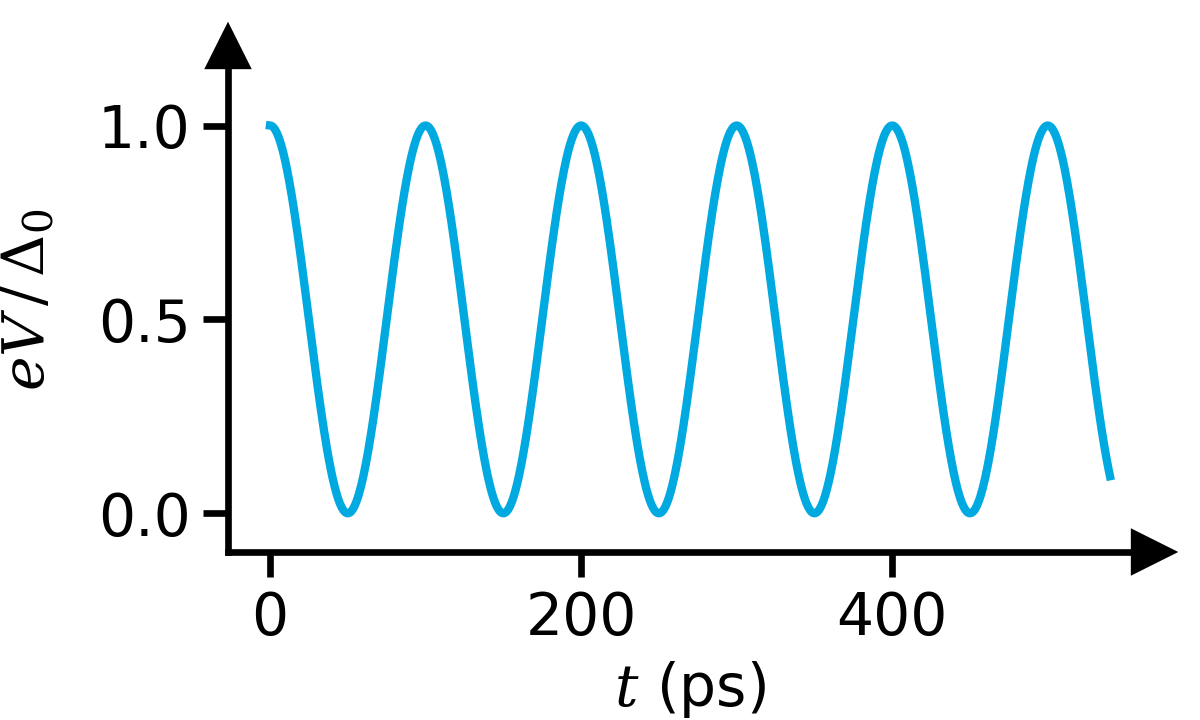

In [7]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2), padding=(0.3, 0.2))

ax.plot(
    t_ps,
    V,
    color=sc.seeblau100,
)

ax.set_ylim(-0.1, 1.2)

xlabel = "$t$ (ps)"
ylabel = "$eV\\,/\\,\\Delta_0$"
title = "theory/basics/mw-V"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

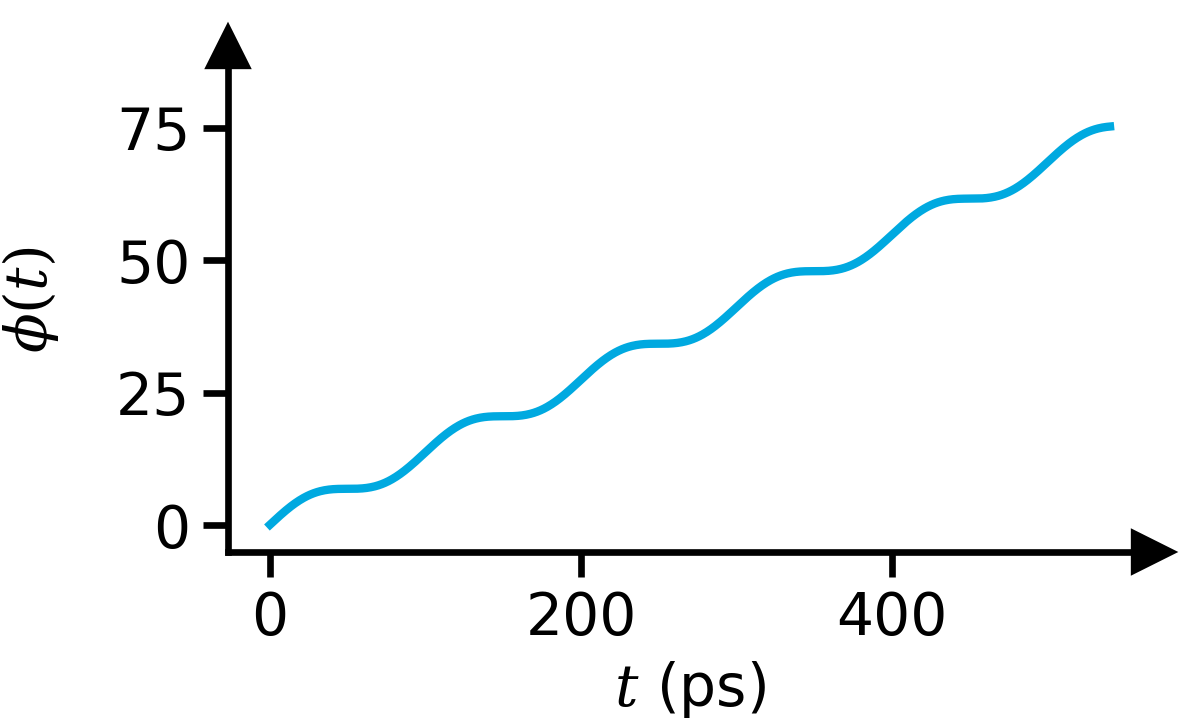

In [8]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2), padding=(0.3, 0.2))

ax.plot(
    t_ps,
    phi,
    color=sc.seeblau100,
)

ax.set_ylim(-5, 90)

xlabel = "$t$ (ps)"
ylabel = "$\\phi(t)$"
title = "theory/basics/mw-phi"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

Substituting symbol \Re from STIXGeneral
Substituting symbol \Re from STIXGeneral
Substituting symbol \Re from STIXGeneral


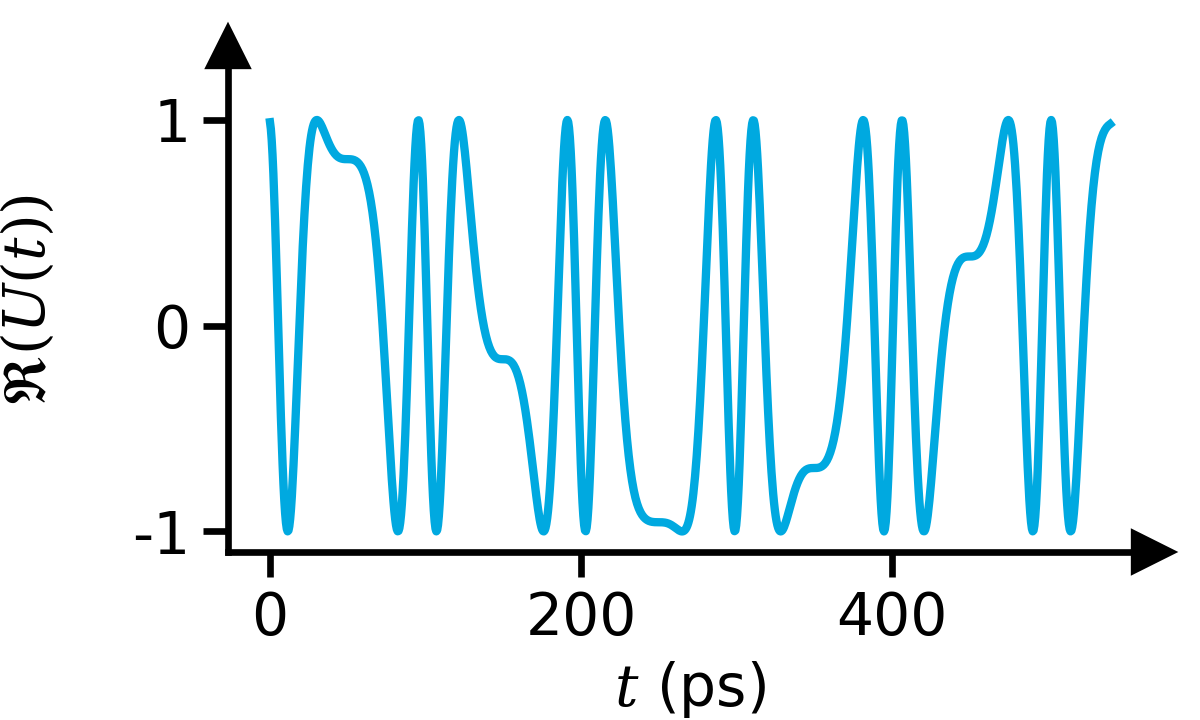

In [9]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2), padding=(0.3, 0.2))

ax.plot(
    t_ps,
    np.real(U),
    color=sc.seeblau100,
)

ax.set_ylim(-1.1, 1.35)

xlabel = "$t$ (ps)"
ylabel = "$\\Re\\,\\!(U(t))$"
title = "theory/basics/mw-ReU"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

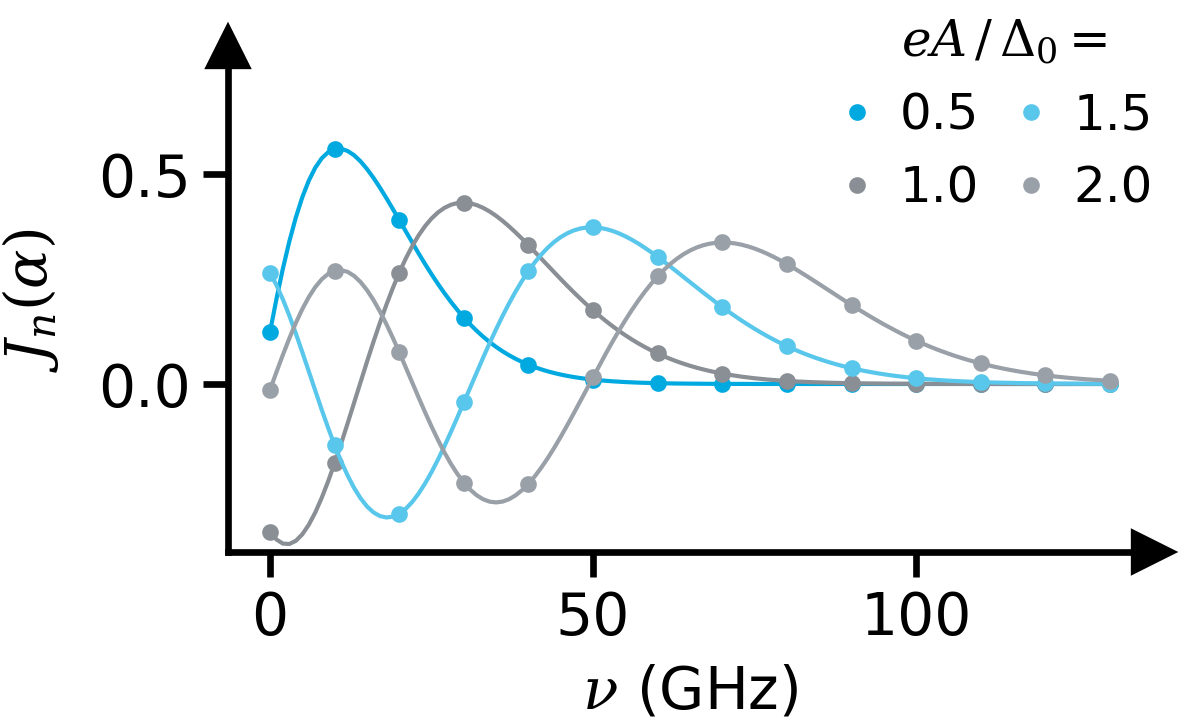

In [10]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2), padding=(0.3, 0.2))

color = [
    sc.seeblau100,
    sc.seegrau80,
    sc.seeblau65,
    sc.seegrau65,
    sc.seeblau35,
    sc.seegrau35,
]

for i, a in enumerate(alpha):
    ax.plot(
        n0 * nu_GHz,
        j0[i, :],
        ".",
        ms=2,
        zorder=i + 4,
        color=color[i],
        label=f"{A[i]}",
    )
    ax.plot(
        n1 * nu_GHz,
        j1[i, :],
        "-",
        lw=0.5,
        zorder=i + 4,
        color=color[i],
    )

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.1,
    loc="upper right",
    bbox_to_anchor=(1.05, 1.15),
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=2,
    columnspacing=1.0,
)
ax.set_ylim(-0.4, 0.8)

xlabel = "$\\nu$ (GHz)"
ylabel = "$J_n(\\alpha)$"
title = "theory/basics/mw-Jn"

sc.theory_layout(fig, ax, title, xlabel, ylabel)